In [1]:
from dotenv import load_dotenv
import json
import os
from langchain.prompts import SystemMessagePromptTemplate
from langchain_core.messages import AIMessage, SystemMessage, BaseMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, NotRequired, TypedDict


MODEL = "mistral-nemo"
TEMPERATURE = 0
load_dotenv('.env', override=True)


class State(TypedDict):
    # messages: Annotated[list[str], add_messages]
    messages: list[BaseMessage]
    claim: str
    evidence: list[str]
    label: str | None
    justification: str | None

# Any tools needed?
# tools_in_use = []

llm = ChatOllama(
    model=MODEL, 
    temperature=TEMPERATURE,
    # base_url="http://host.docker.internal:11434", # if running in the studio
    )



"""
4. Define Nodes: functions taking state and returning state
"""
def prompt_prep_node(state: State) -> State:
    with open("prompts/reasoning_agent_system_prompt.txt", "r") as f:
        prompt_text = f.read()
    # Unwind the evidence list to a bullet list
    evidence_str = "\n".join([f"* {e}" for e in state["evidence"]])
    formatted_prompt = prompt_text.format(evidence=evidence_str)
    messages = [SystemMessage(content=formatted_prompt)] + state["messages"]

    return {"messages": messages}
            # "claim": state["claim"],
            # "evidence": state["evidence"]}

    
def reasoning_node(state: State) -> State:
    response = llm.invoke(state['messages'])
    return {"messages": state['messages'] + [response]}

def postprocessing_node(state: State) -> State:
    """
    #TODO: migrate the postprocessing logic to Pydantic/Langchain
    """
    reasoning = state['messages'][-1].content
    prompt = """Format the response into a JSON object with the following keys:
        "label": "true" | "false" | "unknown"
        "justification": "Justification for the label (string)"
    """
    formatted_reasoning = llm.invoke(reasoning + '\n' + prompt)
    results = json.loads(formatted_reasoning.content)
    label = results['label']
    justification = results['justification']
    return {"messages": state['messages'] + [formatted_reasoning],
            "label": label,
            "justification": justification}








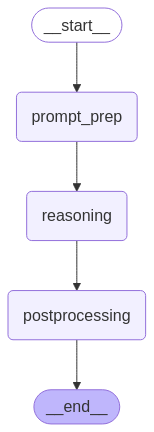

In [ ]:
from IPython.display import Image, display
"""
5. Build the graph
"""

builder = StateGraph(State)
builder.add_node("prompt_prep", prompt_prep_node)
builder.add_node("reasoning", reasoning_node)
builder.add_node("postprocessing", postprocessing_node)

builder.add_edge(START, "prompt_prep")
builder.add_edge("prompt_prep", "reasoning")

builder.add_edge("reasoning", "postprocessing")
builder.add_edge("postprocessing", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
from langchain_core.messages import HumanMessage
claim = "George Washington was the first president of the United States."
evidence = ["George Washington was born in 1732.", "George Washington was a general in the Revolutionary War.", "George Washington was elected president in 1789."]
initial_state = {"messages": [HumanMessage(content=claim)], "claim": claim, "evidence": evidence}
final_state = graph.invoke(initial_state)

In [4]:
print(f"Label: {final_state['label']}")
print(f"Justification: {final_state['justification']}")
print("Messages:")
for m in final_state['messages']:
    m.pretty_print()

Label: true
Justification: George Washington was elected president in 1789, making him the first president of the United States.
Messages:
================================ System Message ================================

You are an analytical reasoning assistant tasked with evaluating factual claims based on evidence.

Your task is to systematically analyze whether the claim is TRUE, FALSE, or UNKNOWN based solely on the provided evidence.

## Evaluation Guidelines:
- TRUE: The evidence directly confirms the claim with clear, specific support
- FALSE: The evidence explicitly contradicts or disproves the claim
- UNKNOWN: The evidence is insufficient, ambiguous, irrelevant, or provides mixed signals

## Analysis Process:
1. Identify key components of the claim that require verification
2. Examine each piece of evidence for relevance and reliability
3. Determine whether the evidence collectively supports, refutes, or is insufficient for the claim
4. Provide a verdict (TRUE/FALSE/UNKNOWN) 